#**UCB**(Upper Confidence Bound) Solving Mutli-Arm Bandits

UCB is often considered to be better than epsilon-greedy because it uses a more sophisticated exploration strategy.

While epsilon-greedy explores randomly with a fixed probability (epsilon), UCB balances exploration and exploitation based on the uncertainty of each action’s estimated reward. It chooses actions with a high upper confidence bound, which considers both the estimated reward and the number of times it has been tried. This makes UCB more efficient regarding the number of trials needed to converge to the optimal action, especially when the number of arms is large or when there is a significant difference in the expected rewards.



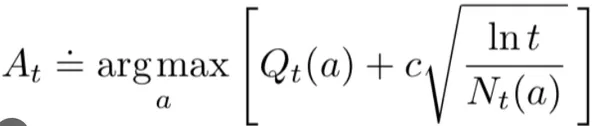


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
class UCB:

    def __init__(self, n_arms, reward_funcs, c=2):
        self.n_arms = n_arms
        self.arm_avg = np.zeros(n_arms)
        self.arm_count = np.ones(n_arms)  # Initialize with 1 to avoid division by zero
        self.reward_funcs = reward_funcs
        self.c = c
        self.total_count = 0
        self.rewards = []

    def initialize(self):
        for arm in range(self.n_arms):
            reward = self.reward_funcs[arm]()
            self.arm_avg[arm] = reward
            self.rewards.append(reward)
        self.total_count = self.n_arms

    def best_arm(self):
        ucb_values = self.arm_avg + self.c * np.sqrt(np.log(self.total_count) / self.arm_count)
        return np.argmax(ucb_values)
      # return np.argmax(self.arm_avg + self.c * (np.array([np.log(self.total_count)])/self.arm_count)**0.5)

    def update(self, arm, reward):
        self.total_count += 1
        self.arm_count[arm] += 1
        self.arm_avg[arm] += (reward - self.arm_avg[arm]) / self.arm_count[arm]
        self.rewards.append(reward)

In [71]:
def create_custom_arm(n_arms, reward_funcs):
  """
    Create arms with custom reward functions.

    :param n_arms: Number of arms
    :param reward_funcs: List of custom reward functions
    :return: List of reward functions
    """
  assert len(reward_funcs) == n_arms, "Number of reward functions must match the number of arms"
  return reward_funcs


##Reward Functions

In [72]:
def bernoulli_reward(p):
    return lambda: np.random.binomial(1, p)

def normal_reward(mean, std):
    return lambda: np.random.normal(mean, std)

def exponential_reward(scale):
    return lambda: np.random.exponential(scale)

In [73]:
def run(n_arms, n_iters, n_experiments, custom_reward_funcs=None):
    cumulative_rewards = np.zeros((n_experiments, n_iters))
    optimal_arm_selections = np.zeros((n_experiments, n_iters))

    for experiment in range(n_experiments):
        if custom_reward_funcs:
            reward_funcs = create_custom_arm(n_arms, custom_reward_funcs)
        else:
            reward_funcs = [normal_reward(np.random.uniform(0, 1), 1) for _ in range(n_arms)]

        true_means = [np.mean([func() for _ in range(1000)]) for func in reward_funcs]
        optimal_arm = np.argmax(true_means)

        agent = UCB(n_arms, reward_funcs)
        agent.initialize()

        for it in range(n_iters):
            selected_arm = agent.best_arm()
            reward = reward_funcs[selected_arm]()
            agent.update(selected_arm, reward)
            cumulative_rewards[experiment, it] = reward
            optimal_arm_selections[experiment, it] = int(selected_arm == optimal_arm)

    return cumulative_rewards, optimal_arm_selections

##plot

In [74]:
def plot_results(cummulative_rewards, optimal_arm_selections, n_iterations):
  plt.figure(figsize = (12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(np.cumsum(np.mean(cummulative_rewards, axis = 0)))
  plt.title('Cumulative Reward')
  plt.xlabel('Iterations')
  plt.ylabel('Cumulative Reward')

  plt.subplot(1, 2, 2)
  plt.plot(np.cumsum(np.mean(optimal_arm_selections, axis = 0)) / np.arange(1, n_iterations + 1))
  plt.title('Optimal Arm Selection Rate')
  plt.xlabel('Iterations')
  plt.ylabel('Optimal Arm Selection Rate')

  plt.tight_layout()
  plt.show()

In [75]:
custom_rewards = [
    bernoulli_reward(0.7),
    normal_reward(2, 1),
    exponential_reward(1.5),
    lambda: np.random.choice([0, 1, 2, 3], p=[0.4, 0.3, 0.2, 0.1]),
    lambda: max(0, np.random.normal(5, 2))  # Truncated normal
]

In [76]:
n_arms = 5
n_iterations = 1000
n_experiments = 100

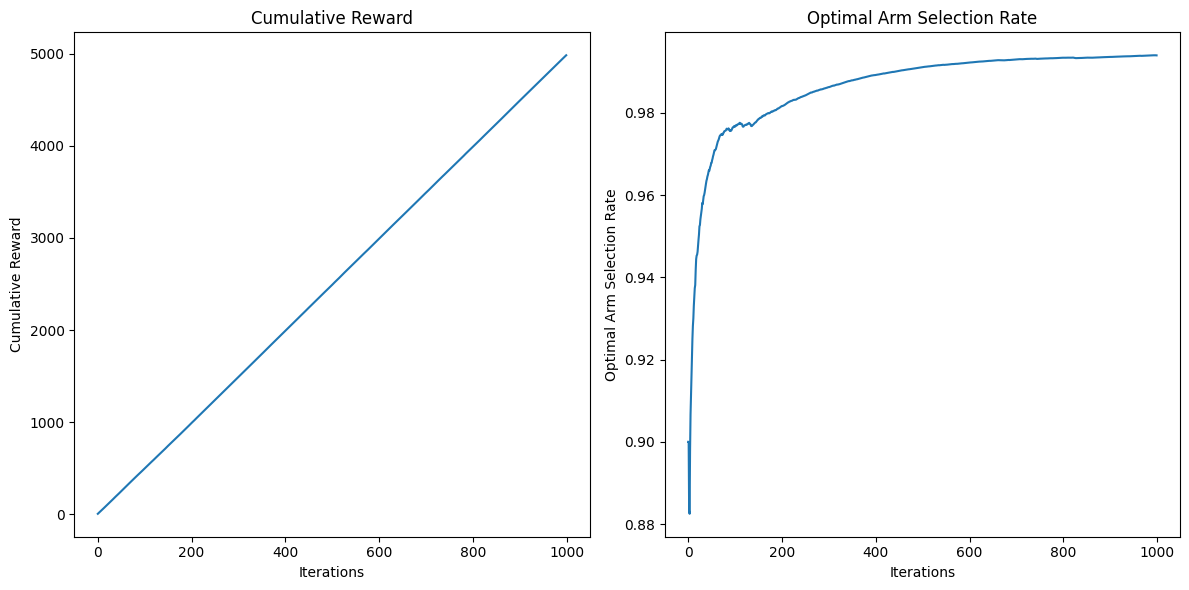

In [77]:
cumulative_rewards, optimal_arm_selections = run(n_arms, n_iterations, n_experiments, custom_rewards)
plot_results(cumulative_rewards, optimal_arm_selections, n_iterations)